In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from IPython.display import clear_output
import random
import os
import nltk
from nltk.tokenize import RegexpTokenizer
from sklearn.metrics import accuracy_score
from keras.callbacks import CSVLogger
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from matplotlib import pyplot
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer, TfidfTransformer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, load_model
from keras.layers import LSTM, GRU
from keras.layers import Dense, Embedding, Bidirectional, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from nltk.stem import SnowballStemmer
import re

In [2]:
train_df = pd.read_csv('train.csv')

test_df = pd.read_csv('test.csv')

# EDA

In [3]:
train_df.sample(10)

,id,keyword,location,text,target
6635,9502,terrorist,NaN,Fresh encounter in Pulwama of J&amp;amp;K one ...,1
3080,4421,electrocute,Mass,@Mmchale13 *tries to electrocute self with pho...,0
5024,7165,mudslide,potters bar,Loved the opener and still feeling guilty for ...,0
1727,2490,collided,On the court,DRob collided into Dan Hughes while she was go...,0
1764,2537,collision,"Peterborough, Ontario, Canada",Two-vehicle collision at Fowlers Corners at Hw...,1
4640,6597,inundated,The Main,I presume my timeline will be inundated with '...,0
1439,2075,casualty,"Toledo, OH",Casualty Team: Ice Cream Recall Sends Chill Th...,0
1390,2006,bush%20fires,NaN,Ted Cruz fires back at Jeb &amp; Bush: ÛÏWe l...,0
5272,7534,oil%20spill,NaN,Refugio oil spill may have been costlier bigge...,1
539,784,avalanche,Buy Give Me My Money,I HAVE GOT MORE VIDEOS THAN YOU RAPPERS GOT SO...,0


In [4]:
# Check shape of data sets
print(f"Train data set shape: {train_df.shape}")
print(f"Test data set shape: {test_df.shape}")

Train data set shape: (7613, 5)
Test data set shape: (3263, 4)


In [5]:
# Check missing values
print(f"Train Dataset missing data: \n{train_df.isnull().sum()}\n")
print(f"Test Dataset missing data: \n{test_df.isnull().sum()}")

Train Dataset missing data: 
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

Test Dataset missing data: 
id             0
keyword       26
location    1105
text           0
dtype: int64


In [6]:
train_df['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

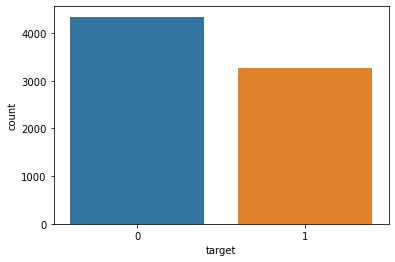

In [7]:
sns.countplot(x='target', data=train_df);

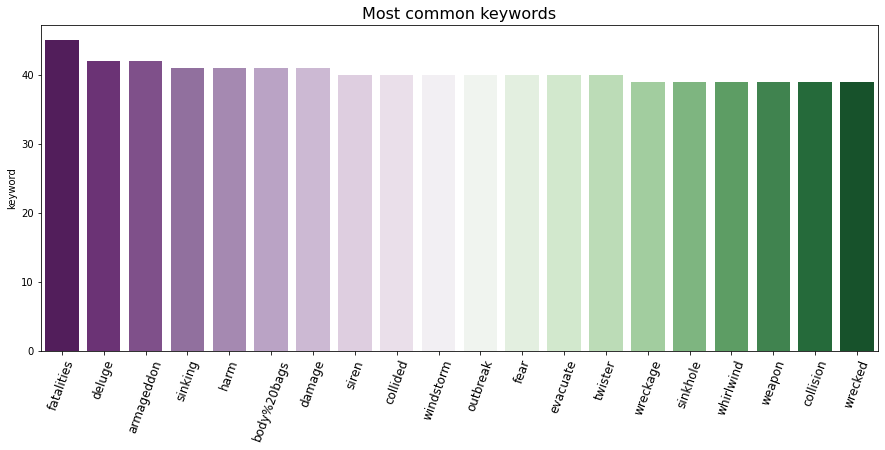

In [8]:
# Check key words
keywords_check = train_df["keyword"].value_counts()[:20].to_frame()

fig = plt.figure(figsize=(15,6))
sns.barplot(data=keywords_check, x=keywords_check.index, y="keyword", palette="PRGn")
plt.title("Most common keywords",size=16)
plt.xticks(rotation=70,size=12);

# Preprocessing

In [9]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\16095\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\16095\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [10]:
def remove_emoji(string):
  '''
  Remove emojies from text
  '''
  emoji_pattern = re.compile("["
  u"\U0001F600-\U0001F64F"
  u"\U0001F300-\U0001F5FF"
  u"\U0001F680-\U0001F6FF"
  u"\U0001F1E0-\U0001F1FF"
  u"\U00002702-\U000027B0"
  u"\U000024C2-\U0001F251"
  u"\U0001f926-\U0001f937"
  u'\U00010000-\U0010ffff'
  u"\u200d"
  u"\u2640-\u2642"
  u"\u2600-\u2B55"
  u"\u23cf"
  u"\u23e9"
  u"\u231a"
  u"\u3030"
  u"\ufe0f"
  "]+", flags=re.UNICODE)
  
  return emoji_pattern.sub(r' ', string)

In [11]:
lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer('english') 

def preprocess(sentence):
  # dtype to string
  sentence=str(sentence)
  # lowercase
  sentence = sentence.lower()
  # remove html links
  sentence = sentence.replace('{html}',"")
  # remove emojies
  sentence = remove_emoji(sentence)
  # remove special characters
  cleanr = re.compile('<.*?>')
  cleantext = re.sub(cleanr, '', sentence)
  # remove urls
  rem_url=re.sub(r'http\S+', '',cleantext)
  # remove numbers
  rem_num = re.sub('[0-9]+', '', rem_url)

  # tokenize text
  tokenizer = RegexpTokenizer(r'\w+')
  tokens = tokenizer.tokenize(rem_num)

  # remove stopwords  
  filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]
  # stemming
  stem_words=[stemmer.stem(w) for w in filtered_words]
  lemma_words=[lemmatizer.lemmatize(w) for w in stem_words]
  
  return " ".join(filtered_words)

text_ls = ['keyword', 'location', 'text']


# Clean train_df
for col in text_ls:
  for i in range(len(train_df[col])):
    train_df[col][i] = preprocess(train_df[col][i])

# Clean test_df
for col in text_ls:
  for i in range(len(test_df[col])):
    test_df[col][i] = preprocess(test_df[col][i])

print("\nTrain Set:")
train_df.head()

<ipython-input-11-e6b96132cf7e>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[col][i] = preprocess(train_df[col][i])
<ipython-input-11-e6b96132cf7e>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[col][i] = preprocess(test_df[col][i])



Train Set:


,id,keyword,location,text,target
0,1,nan,nan,deeds reason earthquake may allah forgive,1
1,4,nan,nan,forest fire near ronge sask canada,1
2,5,nan,nan,residents asked shelter place notified officer...,1
3,6,nan,nan,people receive wildfires evacuation orders cal...,1
4,7,nan,nan,got sent photo ruby alaska smoke wildfires pou...,1


In [12]:
train_df.sample(10)

,id,keyword,location,text,target
3591,5130,fatal,thane,year old boy charged manslaughter toddler repo...,1
3236,4646,emergency services,los angeles,missionhills nursing registered nurse emergenc...,0
1657,2394,collapsed,foreverwithbap,almost collapsed said wish came true moderatel...,0
5517,7871,quarantined,nan,reddit new content policy goes effect many hor...,0
2033,2917,danger,lahar gwalior,indian govt amp media take serious concern saf...,1
3650,5199,fatalities,nan,liked youtube video kevinedwardsjr mortal komb...,0
2918,4197,drown,inside webcam stop,kessily mishacollins send drown like way think...,0
82,119,accident,nan,wait see pissed donnie tell another accident,0
608,877,bioterror,nan,fedex longer transport bioterror germs wake an...,1
6967,9992,tsunami,nan,dont get waves missing anymore theyre like tsu...,1


In [13]:
def define_tokenizer(train_sentences, val_sentences, test_sentences):
  '''
  Takes the train, val, and test data sets and assigning an index number to every word present in the sentences.
  '''
  sentences = pd.concat([train_sentences, val_sentences, test_sentences])
  
  tokenizer = tf.keras.preprocessing.text.Tokenizer()
  tokenizer.fit_on_texts(sentences)
  
  return tokenizer
    
def encode(sentences, tokenizer):
  '''
  Takes the tokenizer to encode all the sentences into an array of index numbers representing the sentence
  '''
  encoded_sentences = tokenizer.texts_to_sequences(sentences)
  encoded_sentences = tf.keras.preprocessing.sequence.pad_sequences(encoded_sentences, padding='post')
  
  return encoded_sentences

In [14]:
# Split out data into train, val, test set
val_data = train_df.tail(1500)
train_data = train_df.head(6113)
test_data = test_df

In [15]:
tokenizer = define_tokenizer(train_data['text'], val_data['text'], test_data['text'])

encoded_sentences = encode(train_data['text'], tokenizer)
val_encoded_sentences = encode(val_data['text'], tokenizer)
encoded_test_sentences = encode(test_data['text'], tokenizer)

In [16]:
tokenizer.word_index['disaster']

12

In [17]:
len(tokenizer.word_index)

19999

In [18]:
# Check if sentences  are lowercase
print(f"Lower: {tokenizer.get_config()['lower']}")

# Check the split to get the words from the sentences
print(f"Split: {tokenizer.get_config()['split']}")

# what characters are filters out
print(f"Filters: {tokenizer.get_config()['filters']}")

Lower: True
Split:  
Filters: !"#$%&()*+,-./:;<=>?@[\]^_`{|}~	



# Embedding

In [20]:
embedding_dict = {}

with open('./glove.6B.100d.txt','r',encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vectors = np.asarray(values[1:],'float32')
        embedding_dict[word] = vectors
        
f.close()

In [21]:
num_words = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((num_words, 100))

for word, i in tokenizer.word_index.items():
    if i > num_words:
        continue
    
    emb_vec = embedding_dict.get(word)
    
    if emb_vec is not None:
        embedding_matrix[i] = emb_vec

# Modeling

## Model 1

In [22]:
tf_data = tf.data.Dataset.from_tensor_slices((encoded_sentences, train_data['target'].values))

def pipeline(tf_data, buffer_size=100, batch_size=32):
    tf_data = tf_data.shuffle(buffer_size)    
    tf_data = tf_data.prefetch(tf.data.experimental.AUTOTUNE)
    tf_data = tf_data.padded_batch(batch_size, padded_shapes=([None],[]))
    
    return tf_data

tf_data = pipeline(tf_data, buffer_size=1000, batch_size=32)

In [23]:
print(tf_data)

<PaddedBatchDataset shapes: ((None, None), (None,)), types: (tf.int32, tf.int64)>


In [24]:
# create pipeline for validation set
tf_val_data = tf.data.Dataset.from_tensor_slices((val_encoded_sentences, val_data['target'].values))

def val_pipeline(tf_data, batch_size=1):        
    tf_data = tf_data.prefetch(tf.data.experimental.AUTOTUNE)
    tf_data = tf_data.padded_batch(batch_size, padded_shapes=([None],[]))
    
    return tf_data

tf_val_data = val_pipeline(tf_val_data, batch_size=len(val_data))

In [25]:
print(tf_val_data)

<PaddedBatchDataset shapes: ((None, None), (None,)), types: (tf.int32, tf.int64)>


In [26]:
embedding = tf.keras.layers.Embedding(
    len(tokenizer.word_index) + 1,
    100,
    embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix),
    trainable = True
)

In [27]:
model = tf.keras.Sequential([
    embedding,
    tf.keras.layers.SpatialDropout1D(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, dropout=0.2, recurrent_dropout=0.2)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [28]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(0.0001),
    metrics=['accuracy', 'Precision', 'Recall']
)

In [29]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=2, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1),
]

In [30]:
history = model.fit(
    tf_data, 
    validation_data = tf_val_data,
    epochs = 50,
    callbacks = callbacks
)

clear_output()

In [32]:
metrics = model.evaluate(tf_val_data)
# print(model.metrics_names)


precision = metrics[2]
recall = metrics[3]
f1 = 2 * (precision * recall) / (precision + recall)

print(f'Accuracy score: {metrics[1]}')
print(f'F1 score: {str(f1)}')

1/1 [==============================] - 0s 0s/step - loss: 0.5954 - accuracy: 0.8160 - precision: 0.8824 - recall: 0.7021
Accuracy score: 0.8159999847412109
F1 score: 0.7819905091365847


In [33]:
data = {'loss': history.history['loss'],
        'accuracy':  history.history['accuracy'],
        'precision': history.history['precision'],
        'recall': history.history['recall'],
        'val_loss': history.history['val_loss'],
        'val_accuracy': history.history['val_accuracy']
        }

hist_df = pd.DataFrame(data)

hist_df.head()

,loss,accuracy,precision,recall,val_loss,val_accuracy
0,0.702646,0.610502,0.645669,0.159782,0.620457,0.771333
1,0.638512,0.760183,0.832930,0.536243,0.604167,0.802667
2,0.631287,0.771143,0.851294,0.551052,0.597738,0.799333
3,0.626238,0.788156,0.839658,0.612237,0.596364,0.801333
4,0.620521,0.796499,0.871348,0.604443,0.596818,0.803333


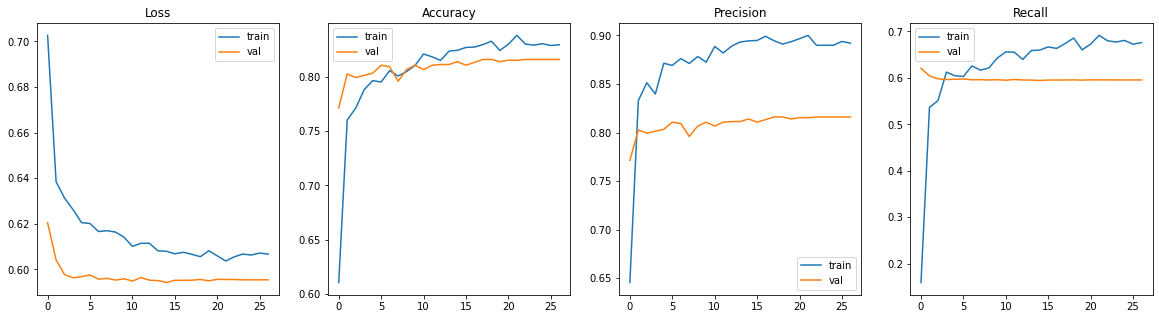

In [34]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

axs[0].set_title('Loss')
axs[0].plot(hist_df['loss'], label='train')
axs[0].plot(hist_df['val_loss'], label='val')
axs[0].legend()

axs[1].set_title('Accuracy')
axs[1].plot(hist_df['accuracy'], label='train')
axs[1].plot(hist_df['val_accuracy'], label='val')
axs[1].legend()

axs[2].set_title('Precision')
axs[2].plot(hist_df['precision'], label='train')
axs[2].plot(hist_df['val_accuracy'], label='val')
axs[2].legend()

axs[3].set_title('Recall')
axs[3].plot(hist_df['recall'], label='train')
axs[3].plot(hist_df['val_loss'], label='val')
axs[3].legend()

In [35]:
# Check for number of false positives
predictions = model.predict(tf_val_data)
predictions = np.concatenate(predictions).round().astype(int)
val_data['predictions'] = predictions

false_positives = val_data[(val_data['predictions'] == 1) & (val_data['target'] == 0)]

print(f'Count of false positives: {str(len(false_positives))}\n\n')

Count of false positives: 66




<ipython-input-35-85f783c09aef>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_data['predictions'] = predictions


In [36]:
# Look at false positives
false_positives.head(10)

,id,keyword,location,text,target,predictions
6240,8912,snowstorm,south usa,sassy city girl country hunk stranded smoky mo...,0,1
6257,8941,snowstorm,italy,snowstorm planned outside rome mary major toni...,0,1
6272,8962,storm,philly,okay welcome rain gave storm could weather,0,1
6277,8968,storm,johns creek,storm,0,1
6278,8969,storm,new delhi,johngreen storm silence robthier_en,0,1
6287,8980,storm,phantrash,sky clear storm passed still raining head,0,1
6336,9058,structural failure,india,excessive engine failure rate significant main...,0,1
6350,9080,structural failure,warm heart africa,sabcnewsroom sabotage rule structural failure,0,1
6351,9081,structural failure,ìït,catoinstitute causes federal failure deeply st...,0,1
6361,9093,suicide bomb,nan,foxnewsinsider obama giving false time schedul...,0,1


In [37]:
# Check for number of false negatives
false_negatives = val_data[(val_data['predictions'] == 0) & (val_data['target'] == 1)]

print(f'Count of false negatives: {str(len(false_negatives))}')

Count of false negatives: 210


In [38]:
# Look at false negatives
false_positives.tail(10)

,id,keyword,location,text,target,predictions
7311,10464,wild fires,johannesburg south africa,load shedding permanently live like wild camp ...,0,1
7330,10490,wildfire,vail valley,fire safety plan matt_kroschel mock wildfire n...,0,1
7412,10605,wounded,nan,ever seen president killed wounded child man c...,0,1
7442,10650,wounds,earth,dianneg gunshot wound bicep wounds chest torso...,0,1
7445,10656,wounds,lake highlands,crack path wiped morning beach run surface wou...,0,1
7453,10666,wounds,cape town,thought surgical wounds healed weather helping...,0,1
7467,10684,wounds,charlotte,says many wounds could fatal rather quickly ot...,0,1
7472,10689,wreck,nan,wreck wreck wreck wreck wreck wreck wreck wrec...,0,1
7487,10709,wreck,nan,emotions train wreck body train wreck wreck,0,1
7551,10794,wrecked,nan,freeway africa til wrecked audi,0,1


In [39]:
tf_test_data = tf.data.Dataset.from_tensor_slices((encoded_test_sentences))

def test_pipeline(tf_data, batch_size=1):        
    tf_data = tf_data.prefetch(tf.data.experimental.AUTOTUNE)
    tf_data = tf_data.padded_batch(batch_size, padded_shapes=([None]))
    
    return tf_data

tf_test_data = test_pipeline(tf_test_data)

In [40]:
pred = model.predict(tf_test_data)

In [41]:
pred = np.concatenate(pred).round().astype(int)

In [43]:
sub = pd.DataFrame(data={'target': pred}, index=test_data['id'])
sub.index = sub.index.rename('id')
sub.to_csv('submission1.csv')

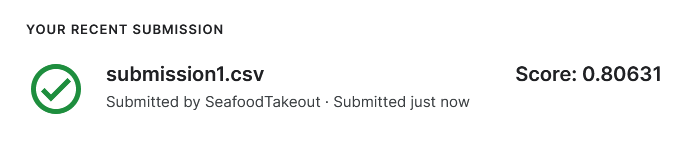

In [74]:
from IPython import display
display.Image("submisson1.png")

# Model 2

In [44]:
model2 = tf.keras.Sequential([
    embedding,
    tf.keras.layers.SpatialDropout1D(0.2),
    tf.keras.layers.Dense(1, activation='relu'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, dropout=0.2, recurrent_dropout=0.2)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [45]:
model2.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(0.0001),
    metrics=['accuracy', 'Precision', 'Recall']
)

In [46]:
callbacks2 = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=2, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1),
]

In [47]:
history2 = model2.fit(
    tf_data, 
    validation_data = tf_val_data,
    epochs = 50,
    callbacks = callbacks2
)

clear_output()

In [71]:
metrics2 = model2.evaluate(tf_val_data)
# print(model.metrics_names)


precision2 = metrics2[2]
recall2 = metrics2[3]
f1 = 2 * (precision * recall) / (precision + recall)

print(f'Accuracy score: {metrics2[1]}')
print(f'F1 score: {str(f1)}')

1/1 [==============================] - 0s 0s/step - loss: 0.6932 - accuracy: 0.5300 - precision: 0.0000e+00 - recall: 0.0000e+00
Accuracy score: 0.5299999713897705
F1 score: 0.7819905091365847


In [72]:
data2 = {'loss': history2.history['loss'],
        'accuracy':  history2.history['accuracy'],
        'precision': history2.history['precision'],
        'recall': history2.history['recall'],
        'val_loss': history2.history['val_loss'],
        'val_accuracy': history2.history['val_accuracy']
        }

hist_df2 = pd.DataFrame(data2)

hist_df2.head()

,loss,accuracy,precision,recall,val_loss,val_accuracy
0,0.724483,0.571732,0.290323,0.01403,0.693388,0.53
1,0.693195,0.580239,0.000000,0.00000,0.693193,0.53
2,0.693157,0.580239,0.000000,0.00000,0.693167,0.53
3,0.693151,0.580239,0.000000,0.00000,0.693158,0.53
4,0.693150,0.580239,0.000000,0.00000,0.693157,0.53


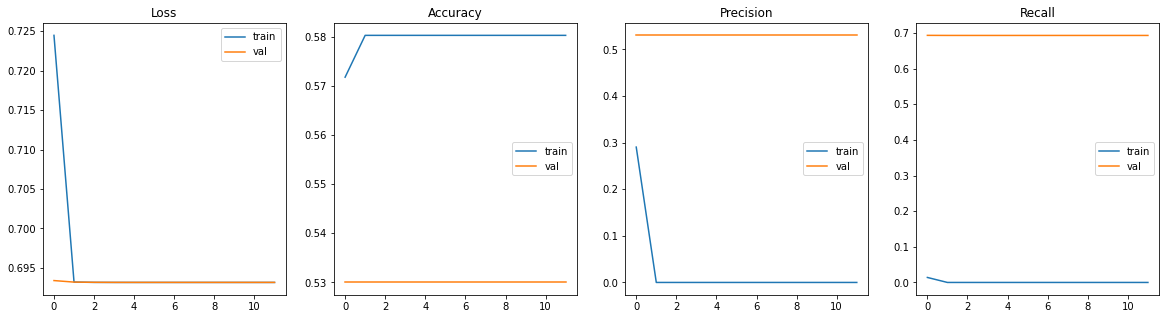

In [63]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

axs[0].set_title('Loss')
axs[0].plot(hist_df2['loss'], label='train')
axs[0].plot(hist_df2['val_loss'], label='val')
axs[0].legend()

axs[1].set_title('Accuracy')
axs[1].plot(hist_df2['accuracy'], label='train')
axs[1].plot(hist_df2['val_accuracy'], label='val')
axs[1].legend()

axs[2].set_title('Precision')
axs[2].plot(hist_df2['precision'], label='train')
axs[2].plot(hist_df2['val_accuracy'], label='val')
axs[2].legend()

axs[3].set_title('Recall')
axs[3].plot(hist_df2['recall'], label='train')
axs[3].plot(hist_df2['val_loss'], label='val')
axs[3].legend()

In [51]:
pred2 = model2.predict(tf_test_data)

In [52]:
pred2 = np.concatenate(pred2).round().astype(int)

In [53]:
sub2 = pd.DataFrame(data={'target': pred2}, index=test_data['id'])
sub2.index = sub2.index.rename('id')
sub2.to_csv('submission2.csv')

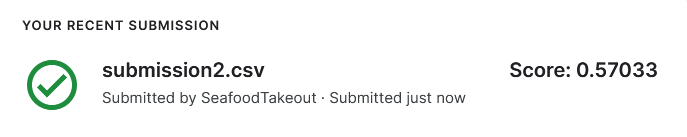

In [76]:
display.Image("submission2.png")

# Model 3

In [57]:
model3 = tf.keras.Sequential([
    embedding,
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.SpatialDropout1D(0.2),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, dropout=0.2, recurrent_dropout=0.2)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [58]:
model3.compile(
  loss="binary_crossentropy",
  optimizer=tf.keras.optimizers.Adam(),
  metrics=['accuracy', 'Precision', 'Recall']
)

In [59]:
callbacks3 = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=2, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1),
]

In [60]:
history3 = model3.fit(
    tf_data, 
    validation_data = tf_val_data,
    epochs=50,
    callbacks = callbacks3
)

clear_output()

In [64]:
metrics3 = model3.evaluate(tf_val_data)
# print(model.metrics_names)


precision3 = metrics3[2]
recall3 = metrics3[3]
f1 = 2 * (precision3 * recall3) / (precision3 + recall3)

print(f'Accuracy score: {metrics3[1]}')
print(f'F1 score: {str(f1)}')

1/1 [==============================] - 0s 0s/step - loss: 1.2890 - accuracy: 0.7320 - precision: 0.6945 - recall: 0.7674
Accuracy score: 0.7319999933242798
F1 score: 0.7291105222536299


In [65]:
data3 = {'loss': history3.history['loss'],
        'accuracy':  history3.history['accuracy'],
        'precision': history3.history['precision'],
        'recall': history3.history['recall'],
        'val_loss': history3.history['val_loss'],
        'val_accuracy': history3.history['val_accuracy']
        }

hist_df3 = pd.DataFrame(data3)

hist_df3.head()

,loss,accuracy,precision,recall,val_loss,val_accuracy
0,0.505056,0.760347,0.792353,0.581450,0.403739,0.822000
1,0.370739,0.848192,0.864324,0.757210,0.404596,0.820667
2,0.294433,0.884508,0.895408,0.820733,0.425588,0.809333
3,0.205289,0.921970,0.924076,0.886984,0.486307,0.792667
4,0.150415,0.944872,0.944201,0.923227,0.548027,0.774667


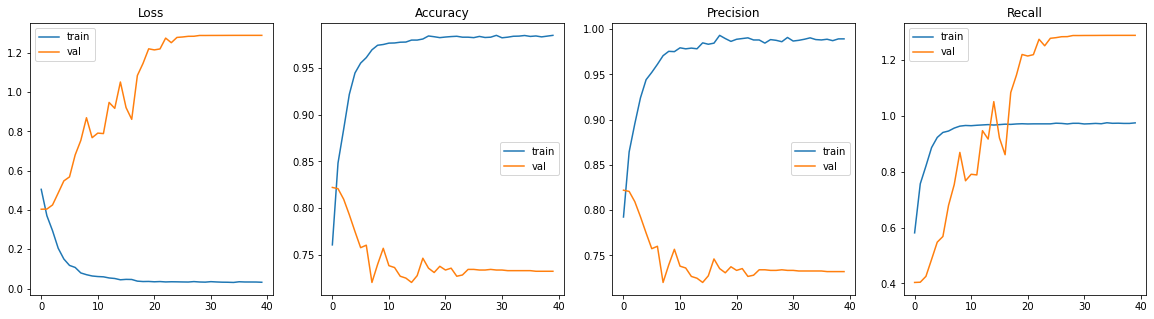

In [66]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

axs[0].set_title('Loss')
axs[0].plot(hist_df3['loss'], label='train')
axs[0].plot(hist_df3['val_loss'], label='val')
axs[0].legend()

axs[1].set_title('Accuracy')
axs[1].plot(hist_df3['accuracy'], label='train')
axs[1].plot(hist_df3['val_accuracy'], label='val')
axs[1].legend()

axs[2].set_title('Precision')
axs[2].plot(hist_df3['precision'], label='train')
axs[2].plot(hist_df3['val_accuracy'], label='val')
axs[2].legend()

axs[3].set_title('Recall')
axs[3].plot(hist_df3['recall'], label='train')
axs[3].plot(hist_df3['val_loss'], label='val')
axs[3].legend()

In [67]:
pred3 = model3.predict(tf_test_data)

In [68]:
pred3 = np.concatenate(pred3).round().astype(int)

In [69]:
sub3 = pd.DataFrame(data={'target': pred3}, index=test_data['id'])
sub3.index = sub3.index.rename('id')
sub3.to_csv('submission3.csv')

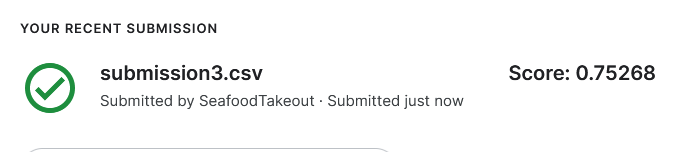

In [77]:
display.Image("submission3.png")

# Conclusion

This was a difficult assignment with many roadblocks to getting my models to run properly. After several attempts and quite a few different approaches, I finally got my models to run properly--atleast most of them. Model 1 performed best overall and model 3 was not far behind. However, I had a hard time getting Model 2 to run properly and it shows in the performance. I assume its a simple mistake somewhere, but I could not seem to troubleshoot this issue. Nevertheless, I was able to get it to run. 